In [31]:
### import part ###

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.datasets import mnist
from keras import layers as L
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from IPython import display
from tqdm import tnrange
plt.rcParams.update({'axes.titlesize': 'small'})
%matplotlib inline

In [32]:
(x_train, _ ), (_, _) = mnist.load_data()

data = np.expand_dims(x_train, axis=3)
IMG_SHAPE = data.shape[1:]

# gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.333)
s = tf.Session()

In [33]:
## Generator part

CODE_SIZE = int(input("Please, enter a code size \n"))

generator = Sequential()

generator.add(L.InputLayer([CODE_SIZE], name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))
generator.add(L.Reshape((8, 8, 10)))
generator.add(L.Deconv2D(64, (5, 5), activation='elu'))
generator.add(L.Deconv2D(64, (5, 5), activation='elu'))
generator.add(L.UpSampling2D(size=(2, 2)))
generator.add(L.Conv2D(32, (3, 3), activation='elu'))
generator.add(L.Conv2D(1, (3, 3), activation=None))

generator.summary()

Please, enter a code size 
256
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (InputLayer)           (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 640)               164480    
_________________________________________________________________
reshape_6 (Reshape)          (None, 8, 8, 10)          0         
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 12, 12, 64)        16064     
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 16, 16, 64)        102464    
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 30, 30, 3

In [34]:
## Discriminator part

discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))
discriminator.add(L.Conv2D(32, kernel_size=(5, 5), activation='elu'))
discriminator.add(L.Conv2D(32, kernel_size=(5, 5), activation='elu'))
discriminator.add(L.MaxPooling2D((2, 2)))
discriminator.add(L.Conv2D(64, kernel_size=(5, 5), activation='elu'))
discriminator.add(L.Conv2D(64, kernel_size=(5, 5), activation='elu'))
discriminator.add(L.Flatten())
discriminator.add(L.Dense(128, activation='tanh'))
discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 6, 6, 64)          51264     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 2, 2, 64)          102464    
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
__________

In [35]:
noise = tf.placeholder('float32', [None, CODE_SIZE])
real_data = tf.placeholder('float32', [None, ]+list(IMG_SHAPE))
logp_real = discriminator(real_data)
generated_data = generator(noise)  #generated images
logp_gen = discriminator(generated_data)

In [36]:
d_loss = -tf.reduce_mean(logp_real[:, 1] + logp_gen[:, 0])

#regularize
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#optimize
disc_optimizer = tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss, var_list=discriminator.trainable_weights)


g_loss = -tf.reduce_mean(discriminator(generator(noise))[:, 1])

gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss, var_list=generator.trainable_weights)

s.run(tf.global_variables_initializer())

In [37]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images) != 0:
        images = images.clip(np.min(data), np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow, ncol, i+1)
        img = np.squeeze(images[i], axis=2)
        if sharp:
            plt.imshow(img)
        else:
            plt.imshow(img)
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:, 1],
             label='D(x)', alpha=0.5, range=[0, 1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:, 1],
             label='D(G(z))', alpha=0.5, range=[0, 1])
    plt.legend(loc='best')
    plt.show()

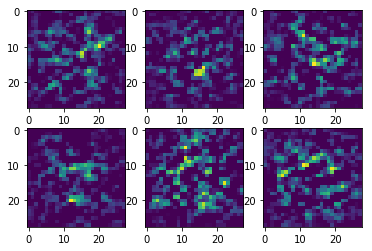

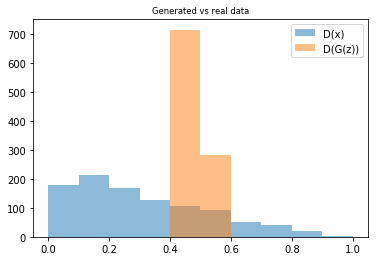

KeyboardInterrupt: 

In [38]:

for epoch in tnrange(25000):

    feed_dict = {
        real_data: sample_data_batch(100),
        noise: sample_noise_batch(100)
    }

    for i in range(5):
        s.run(disc_optimizer, feed_dict)

    s.run(gen_optimizer, feed_dict)

    if epoch % 10 == 0:
        display.clear_output(wait=True)
        sample_images(2, 3, True)
        sample_probas(1000)
